In [ ]:
'''
#Google Colab Only
from google.colab import drive
drive.mount('/content/drive')
'''

Mounted at /content/drive


In [ ]:
#install requirements
!pip install segmentation-models-pytorch albumentations torch torchvision torchaudio torchmetrics tensorflow pandas matplotlib scikit-learn scipy tqdm pillow imageio


In [ ]:
# for data load
import os
import pandas as pd
from glob import glob
import segmentation_models_pytorch as smp
import tensorflow as tf
from segmentation_models_pytorch.losses import DiceLoss
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
from sklearn.metrics import precision_score, recall_score, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
#from google.colab import files



In [ ]:
#upload kaggle token and download dataset
'''
#Google Colab Only
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/

!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip -d /content/dataset
'''

In [ ]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in path1:
        orig_img.append(file)
    for file in path2:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img



In [ ]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2, n_slices=3):
    """
    Processes the images and mask present in the shared list and path.
    Each input sample includes `n_slices` adjacent slices (center ±N).
    Returns:
        X - Image stack of shape (m, H, W, n_slices)
        y - Corresponding masks of shape (m, H, W, 1)
    """
    import numpy as np
    from PIL import Image
    import os

    m = len(img)  # number of total slices
    i_h, i_w, _ = target_shape_img
    m_h, m_w, m_c = target_shape_mask

    # Image shape now includes n_slices as channels
    X = np.zeros((m, i_h, i_w, n_slices), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.float32)

    half = n_slices // 2

    for index in range(m):
        slice_stack = []

        for offset in range(-half, half + 1):
            slice_idx = index + offset
            # Handle boundaries by clamping the index
            slice_idx = max(0, min(slice_idx, m - 1))
            adj_file = img[slice_idx]
            adj_path = os.path.join(path1[slice_idx], adj_file)

            adj_img = Image.open(adj_path).convert('L')  # grayscale
            adj_img = adj_img.resize((i_h, i_w))
            adj_img = np.array(adj_img, dtype=np.float32) / 255.0
            slice_stack.append(adj_img)

        # Stack into (H, W, n_slices)
        stacked_img = np.stack(slice_stack, axis=-1)
        X[index] = stacked_img

        # Load and process mask (same as original)
        mask_file = mask[index]
        mask_path = os.path.join(path2[index], mask_file)
        single_mask = Image.open(mask_path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.array(single_mask, dtype=np.float32)
        single_mask[single_mask == 255] = 1
        single_mask[single_mask > 1] = 1
        single_mask = np.reshape(single_mask, (m_h, m_w, m_c))
        y[index] = single_mask

    return X, y


In [ ]:
def compute_metrics(y_true, y_pred):
    y_pred_bin = (y_pred > 0.5).astype(np.uint8)  # Convert to binary mask

    dice = dice_coefficient(y_true, y_pred_bin).numpy()
    iou_score = iou(y_true, y_pred_bin).numpy()

    precision = precision_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)
    recall = recall_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)

    hausdorff_dist = directed_hausdorff(y_true.squeeze(), y_pred_bin.squeeze())[0]

    return {
        'Dice Coefficient': dice,
        'IoU': iou_score,
        'Precision': precision,
        'Recall': recall,
        'Hausdorff Distance': hausdorff_dist
    }


In [ ]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)

    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments

    return [patient_id, path, f'{path_no_ext}_mask{ext}']

files_dir = '/content/dataset/lgg-mri-segmentation/kaggle_3m'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')
train_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
print(train_df)

In [ ]:
#Replace with your path to data.csv within the dataset
data_df = pd.read_csv('/content/dataset/lgg-mri-segmentation/kaggle_3m/data.csv')

/tmp/ipython-input-3247516104.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1[i])
/tmp/ipython-input-3247516104.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2[i])


(256, 256, 3)
(256, 256)


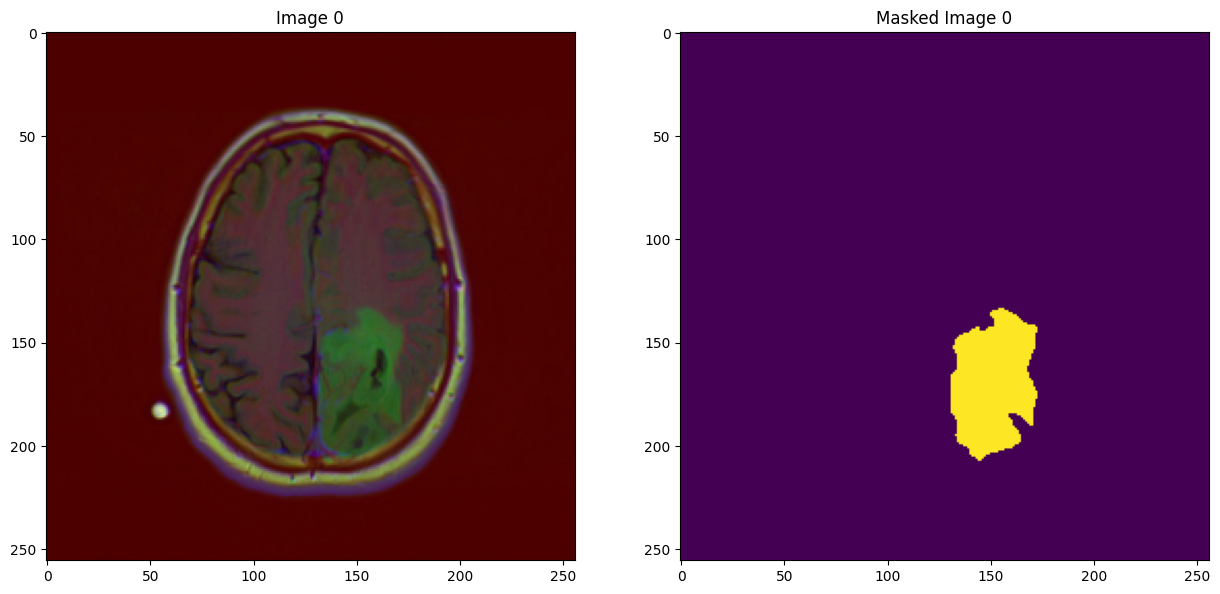

In [ ]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = train_df["image_filename"].tolist()
path2 = train_df["mask_filename"].tolist()
img, mask = LoadData (path1, path2)


# View an example of image and corresponding mask
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1[i])
    mask_view = imageio.imread(path2[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (3929, 256, 256, 3)
Y shape: (3929, 256, 256, 1)
[0. 1.]


Text(0.5, 1.0, 'Processed Masked Image')

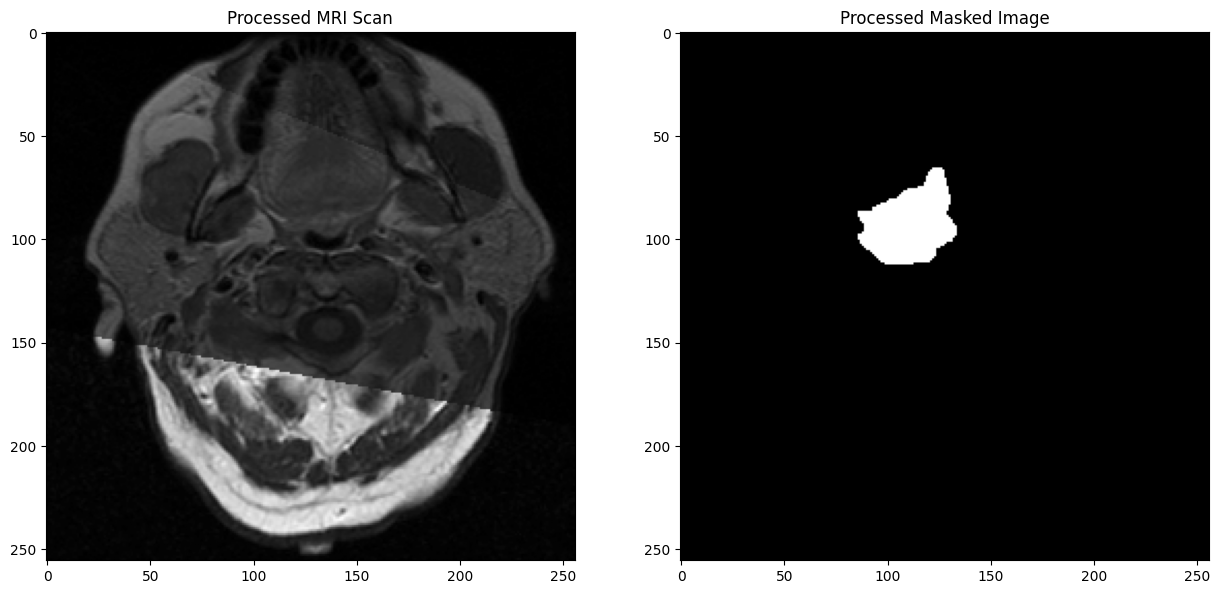

In [ ]:
# Define the desired shape
target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 2 classes : background, tumor
print(np.unique(y))

# Visualize the output
image_index = 1
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index, :, :, 0], cmap='gray')  # Show MRI image in grayscale
arr[0].set_title('Processed MRI Scan')

arr[1].imshow(y[image_index, :, :, 0], cmap='gray')  # Show mask in grayscale
arr[1].set_title('Processed Masked Image')


In [ ]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set# --- Patient-level train/val split ---
patients = train_df["Patient"].unique()
train_patients, val_patients = train_test_split(
    patients, test_size=0.2, random_state=42
)

train_df_split = train_df[train_df["Patient"].isin(train_patients)]
val_df_split = train_df[train_df["Patient"].isin(val_patients)]

# Prepare file lists
train_images, train_masks = LoadData(
    train_df_split["image_filename"].tolist(),
    train_df_split["mask_filename"].tolist()
)
val_images, val_masks = LoadData(
    val_df_split["image_filename"].tolist(),
    val_df_split["mask_filename"].tolist()
)

# Process into arrays with new 256x256 size
X_train, y_train = PreprocessData(
    train_images, train_masks,
    target_shape_img, target_shape_mask,
    train_df_split["image_filename"].tolist(),
    train_df_split["mask_filename"].tolist()
)

X_valid, y_valid = PreprocessData(
    val_images, val_masks,
    target_shape_img, target_shape_mask,
    val_df_split["image_filename"].tolist(),
    val_df_split["mask_filename"].tolist()
)


In [ ]:
# =========================
# Dataset with Albumentations
# =========================
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=None):
        self.images = images  # already numpy arrays
        self.masks = masks    # already numpy arrays
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]   # shape [H,W,C]
        mask = self.masks[idx]     # shape [H,W,1] or [H,W]

        # Ensure correct types
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)
        mask = (mask > 0.5).astype(np.float32)  # binarize

        # Albumentations expects HWC
        if self.augment:
            augmented = self.augment(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Convert to tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # [C,H,W]
        if mask.ndim == 2:  # [H,W]
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)    # [1,H,W]
        else:  # [H,W,1]
            mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)

        return image, mask



# =========================
# Augmentation Pipelines
# =========================
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(p=0.3),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
])

valid_transform = A.Compose([
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
])


# =========================
# Datasets and Loaders
# =========================
train_dataset = SegmentationDataset(
    X_train,
    y_train,
    augment=train_transform
)

val_dataset = SegmentationDataset(
    X_valid,
    y_valid,
    augment=valid_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

In [ ]:
class BCEDiceLoss(nn.Module):
  def __init__(self, bce_weight=0.5):
    super().__init__()
    self.dice = smp.losses.DiceLoss(mode = "binary")
    self.bce = smp.losses.SoftBCEWithLogitsLoss()
    self.bce_weight = bce_weight

  def forward(self, inputs, targets):
    dice_loss = self.dice(inputs, targets)
    bce_loss = self.bce(inputs, targets)
    return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [ ]:
# Initialize metrics
import torch
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score
from segmentation_models_pytorch.metrics import get_stats, iou_score, f1_score
iou_metric = BinaryJaccardIndex(threshold=0.5)
f1_metric = BinaryF1Score(threshold=0.5)

def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs):
    best_iou = 0.0
    best_threshold = 0.5

    history = {
        'train_loss': [],
        'val_loss': [],
        'iou_score': [],
        'f1_score': [],
        'best_threshold': []
    }

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6)

    for epoch in range(num_epochs):
        # -------- Training --------
        model.train()
        train_losses = []
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        avg_train_loss = np.mean(train_losses)

        # -------- Validation --------
        model.eval()
        val_losses, all_preds, all_targets = [], [], []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_losses.append(loss.item())
                probs = torch.sigmoid(outputs)
                all_preds.append(probs.cpu())
                all_targets.append(targets.cpu())

        # Concatenate
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        avg_val_loss = np.mean(val_losses)

        # -------- Dynamic threshold search --------
        thresholds = np.linspace(0.3, 0.7, 9)
        best_epoch_iou, best_epoch_thr = 0.0, 0.5
        for thr in thresholds:
            preds_bin = (all_preds > thr).float()

# Get stats from predictions and targets
            stats = get_stats(preds_bin.long(), all_targets.long(), mode='binary')

# Compute IoU from stats
            iou = iou_score(*stats)
            iou = iou.mean().item()
            if iou > best_epoch_iou:
                best_epoch_iou, best_epoch_thr = iou, thr

        # F1 at that threshold
        preds_bin = (all_preds > best_epoch_thr).float()
        stats_f1 = get_stats(preds_bin.long(), all_targets.long(), mode='binary')
        f1 = f1_score(*stats_f1)
        avg_f1 = f1.mean().item()

        # Scheduler step
        scheduler.step(best_epoch_iou)

        # Save best model
        if best_epoch_iou > best_iou:
            best_iou, best_threshold = best_epoch_iou, best_epoch_thr
            checkpoint = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "best_iou": best_iou,
                "best_threshold": best_threshold,
                "history": history
            }
            torch.save(checkpoint, f"checkpoint_best_epoch{epoch+1}_iou{best_iou:.4f}_thr{best_threshold:.2f}.pth")
            print(f"✅ Saved best model at IoU={best_iou:.4f}, thr={best_threshold:.2f}")

        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['iou_score'].append(best_epoch_iou)
        history['f1_score'].append(avg_f1)
        history['best_threshold'].append(best_epoch_thr)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"IoU: {best_epoch_iou:.4f} (thr={best_epoch_thr:.2f}) | F1: {avg_f1:.4f}")
        print("-" * 50)

    print(f"🏆 Best IoU overall: {best_iou:.4f} at threshold {best_threshold:.2f}")
    return history, best_threshold, best_iou

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_tensor_image(tensor, title="", is_mask=False):
    # Convert tensor to NumPy for display
    tensor = tensor.squeeze().cpu().numpy()  # Remove any singleton dimensions

    # If it's a mask, we use a different display method (usually binary)
    if is_mask:
        plt.imshow(tensor, cmap='gray')  # Show in grayscale
    else:
        # For images, ensure the tensor is in [H, W, C] format (matplotlib expects channel last)
        if len(tensor.shape) == 3:  # If it's a 3D tensor (e.g., RGB)
            tensor = np.transpose(tensor, (1, 2, 0))  # Change from [C, H, W] to [H, W, C]
        plt.imshow(tensor)

    plt.title(title)
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()

In [ ]:
model = smp.DeepLabV3Plus(backbone_name='resnet101', encoder_weights='imagenet', classes=1, activation=None)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2, betas=(0.9, 0.999), eps=1e-8)
#loss_fn = smp.losses.DiceLoss(mode="binary")
#loss_fn = BCEDiceLoss(bce_weight=0.2)
loss_fn = smp.losses.TverskyLoss(mode = "binary", alpha=0.7, beta=0.3)

In [ ]:
#Train model
history, best_thr, best_iou = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=150
)



In [ ]:
def evaluate_model(model, val_loader, loss_fn, best_threshold=0.5):
    """
    Evaluate the model on val_loader using the best threshold
    discovered during training.
    """
    model.eval()
    val_losses, all_preds, all_targets = [], [], []

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_losses.append(loss.item())
            probs = torch.sigmoid(outputs)
            all_preds.append(probs.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Apply threshold found during training
    preds_bin = (all_preds > best_threshold).float()

    avg_val_loss = np.mean(val_losses)
    avg_iou = smp.metrics.iou_score(preds_bin, all_targets).item()
    avg_f1 = smp.metrics.f1_score(preds_bin, all_targets).item()

    results = {
        'val_loss': avg_val_loss,
        'iou_score': avg_iou,
        'f1_score': avg_f1,
        'threshold': best_threshold
    }

    print(f"📊 Evaluation -> Val Loss: {avg_val_loss:.4f} | IoU: {avg_iou:.4f} | "
          f"F1: {avg_f1:.4f} | Threshold: {best_threshold:.2f}")
    return results
